In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

'''
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass
'''    


'\nif torch.cuda.is_available():\n    torch.set_default_tensor_type(torch.cuda.FloatTensor)\n    print("using cuda:", torch.cuda.get_device_name(0))\n    pass\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\ndevice\n\nfrom multiprocessing import set_start_method\ntry:\n    set_start_method(\'spawn\')\nexcept RuntimeError:\n    pass\n'

In [3]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
             
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        
        return sample, label

In [4]:
real_data = pandas.read_csv('dataset/qm9.csv')
max_alpha = max(real_data['alpha'])
min_alpha = min(real_data['alpha'])
number_of_data = len(real_data)

print("number_of_data", number_of_data, "max_alpha", max_alpha, "min_alpha", min_alpha)
real_data.head(5)

number_of_data 133885 max_alpha 196.62 min_alpha 6.31


,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298
0,C,0.0000,13.21,-0.3877,0.1171,0.5048,35.3641,0.044749,6.469,-40.478930,-40.476062,-40.475117,-40.498597
1,N,1.6256,9.46,-0.2570,0.0829,0.3399,26.1563,0.034358,6.316,-56.525887,-56.523026,-56.522082,-56.544961
2,O,1.8511,6.31,-0.2928,0.0687,0.3615,19.0002,0.021375,6.002,-76.404702,-76.401867,-76.400922,-76.422349
3,C#C,0.0000,16.28,-0.2845,0.0506,0.3351,59.5248,0.026841,8.574,-77.308427,-77.305527,-77.304583,-77.327429
4,C#N,2.8937,12.99,-0.3604,0.0191,0.3796,48.7476,0.016601,6.278,-93.411888,-93.409370,-93.408425,-93.431246


In [5]:
data = pandas.read_csv('dataset/GDB13_Subset-ABCDEFGH.smi', header=None, names=["smiles"])
data.head(5)


,smiles
0,S1C=CC=C1
1,O1C=CC=C1
2,C1CCCC1
3,N1C=CC=C1
4,S1C=CC=N1


,smiles,Molecule
0,S1C=CC=C1,

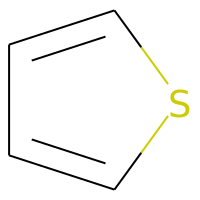

In [6]:
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data = data[0:number_of_data]
data[["smiles","Molecule"]].head(1)


In [7]:
data['smiles'].iloc[10]

'ClC1=CSC=C1'

In [8]:
PandasTools.AddMoleculeColumnToFrame(real_data,'smiles','Molecule')
real_data[["smiles","Molecule"]].head(1)
len(real_data)

133885

In [9]:
from molvecgen.vectorizers import SmilesVectorizer

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(real_data.Molecule.values, )

In [10]:
smivec_data = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec_data.fit(data.Molecule.values, )

In [11]:
# functions to generate random data

def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = torch.round(torch.randn(size) * 10000) / 100
    #round(random.uniform(min_alpha, max_alpha),2)
    return random_data

In [12]:
y = real_data.alpha.values.reshape((-1,1))
X = real_data.Molecule.values

#Normalizing output using standard scaling
scaler = StandardScaler()
X_train = X
y_train = scaler.fit_transform(y)

print('len(X_train)',len(X_train), 'X_train.shape', X_train.shape)

len(X_train) 133885 X_train.shape (133885,)


In [13]:
data_y = generate_random_value(number_of_data).reshape((-1,1))
data_X = data.Molecule.values
scaler = StandardScaler()
data_y = scaler.fit_transform(data_y)
data_dataset = SMILESMolDataset(data_X, data_y, smivec_data)
print('data_dataset[10]', data_dataset[10], 'len(data_dataset[10][0])', len(data_dataset[10][0]) )


data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
   

In [14]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[10]
print('train_dataset[10]', train_dataset[10], 'len(train_dataset[10][0])', len(train_dataset[10][0]) )

train_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
  

In [15]:
# return a random SMILES from the GDB13_Subset
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    #random_data = data_dataset[10]
    return random_data

generate_random_seed(2)[0][1]

array([-0.143398])

In [16]:
epochs = 500
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
out_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
#batch_size = 1   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [17]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer
        #print('LSTM input_size', number_tokens)
         
        
        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)       
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.lr_scheduler = ReduceLROnPlateau(self.optimiser, mode='min', factor=0.5, patience=50, 
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        # combine seed and label
        
        #print("input_tensor.shape", input_tensor.shape, "label_tensor.shape", label_tensor.shape)
        x = torch.cat((input_tensor, label_tensor), -1)
        #print('after torch.cat', x.shape)
        
        
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out
    
    
    def train(self, inputs, label_tensor, targets):
        # calculate the output of the network Discriminator
        outputs = self.forward(inputs, label_tensor)
        
        
        #print('outputs', outputs)
        #print('targets', targets)
        # calculate loss
        #outputs = outputs.view(-1)
        #targets = targets.view(-1)
        #print('outputs.shape', outputs.shape, 'targets.shape',targets.shape)
        
        if (outputs.shape != targets.shape):
            print("Generator loss function issue: outputs.shape != targets.shape", outputs.shape, targets.shape)

        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [18]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )



In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
    label = label.float().to(device)
    label = label.unsqueeze(1).repeat(1, smiles.shape[1], 1)
    D.train(smiles.to(device).float(), label, target)
    
    # fake
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.train(fake_input, fake_label, target)
    
    
    pass

counter =  1000
counter =  2000
CPU times: user 43.9 s, sys: 1.46 s, total: 45.4 s
Wall time: 45.7 s


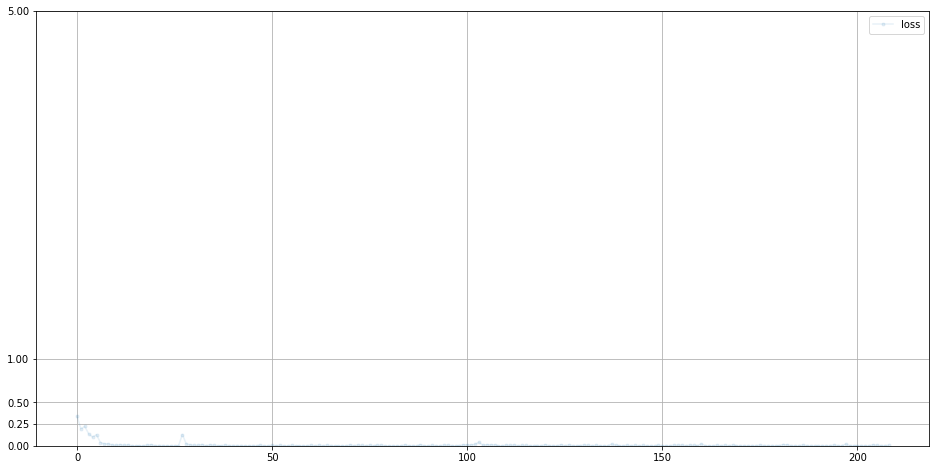

In [21]:
D.plot_progress()

In [22]:

i = 0
for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.unsqueeze(1).repeat(1, smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.forward(fake_input, fake_label)
    pass


tensor([[[0.9195],
         [0.9695],
         [1.1345],
         [0.8841],
         [1.1032],
         [1.0063],
         [1.0014],
         [1.0288],
         [1.0051],
         [1.0264],
         [0.8761],
         [0.9790],
         [1.0979],
         [0.9624],
         [1.0953],
         [0.9295],
         [1.0312],
         [1.0777],
         [0.9341],
         [1.0606],
         [1.0502],
         [1.0521],
         [0.9588],
         [0.9905],
         [1.0222],
         [0.9047],
         [1.0299],
         [1.1263],
         [0.9116],
         [1.0864],
         [1.1141],
         [0.9785],
         [1.0614],
         [1.0078],
         [1.1362],
         [0.9573],
         [1.0795],
         [0.8252],
         [0.8886],
         [0.8688],
         [1.0664],
         [0.9697],
         [0.8598],
         [0.9345],
         [1.1226],
         [0.9395],
         [1.0173],
         [0.9839],
         [0.9869],
         [1.0793],
         [1.1121],
         [1.0545],
         [1.

In [23]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        # initialise parent pytorch class
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(self.batch_size * 2, 1000),
            nn.Sigmoid(),
            nn.Linear(1000,number_of_data)
            #nn.Softmax(dim = 1)
        )
        
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('seed_tensor.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        outputs = self.model(inputs)
        #print('outputs', outputs)
        return F.softmax(outputs, dim=0)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)
        
        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)
        
        
        #print('d_output.shape', d_output.shape, 'targets.shape', targets.shape)
        if (d_output.shape != targets.shape):
            print("Generator loss function issue: d_output.shape != targets.shape", d_output.shape, targets.shape)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def get_index(self, tensor_softmax):
        return torch.argmax(tensor_softmax)

    def get_smiles(self, label):
        #fake_input = torch.FloatTensor(generate_random_seed_G(batch_size)).to(device)
        #fake_label = torch.FloatTensor([label]).to(device)
        
        fake_input = torch.FloatTensor(generate_random_seed_G(self.batch_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(self.batch_size)).to(device)
        idx = torch.argmax(G.forward(fake_input, fake_label).detach()).cpu().numpy()
        
        #idx = self.get_index(G.forward(fake_input, fake_label)).detach().cpu().numpy()
        print(data['smiles'].iloc[idx])
        pass

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [24]:
# check the generator output is of the right type and shape

G = Generator(1)
G.to(device)

#fake = generate_random_seed()
fake_input = torch.FloatTensor(generate_random_seed_G(1)).to(device)
fake_label = torch.FloatTensor(generate_random_value(1)).to(device)
idx = torch.argmax(G.forward(fake_input, fake_label))
data_dataset[idx]



(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0],

In [25]:
G.get_smiles(-12.2323)

C1COCCC2(C1)CCOCCO2


In [26]:
%%time 

D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)

# train Discriminator and Generator

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label in data_loader:
        # train discriminator on true
        #t = torch.FloatTensor([1.0]).view(1,1,1).to(device)
        #label = label.float().to(device)
        #label = label.repeat(smiles.shape[0], smiles.shape[1], 1)
        #D.train(smiles.to(device).float(), label, t)
        
        #########################################################                   
        # train discriminator on true
        #########################################################                   
        target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
        #print('1.before change label.shape', label.shape, 'smiles', smiles.shape)
        label = label.float().to(device)
        label = label.unsqueeze(1).repeat(1, smiles.shape[1], 1)
        D.train(smiles.to(device).float(), label, target)
        
        
        #########################################################                   
        # train discriminator on false
        # use detach() so gradients in G are not calculated
        #########################################################                   
        # fake
        fake_input = []
        fake_label = []
        for finput, label in generate_random_seed(batch_size):
            fake_input.append(finput)
            fake_label.append(label)
    
    
        fake_input = torch.FloatTensor(fake_input).to(device)
        fake_label = torch.FloatTensor(fake_label).to(device)
        fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
        target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
        D.train(fake_input, fake_label, target)
        

        #########################################################                   
        # train generator
        #########################################################                   
        fake_input = torch.FloatTensor(generate_random_seed_G(batch_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_value(batch_size)).to(device)
        data_inx = torch.argmax(G.forward(fake_input, fake_label).detach())
        #print("data_inx", data_inx)

        fake = data_dataset[data_inx]
        #print('fake', fake)
        
        fake_input = torch.FloatTensor(fake[0]).to(device)
        fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
        fake_label = torch.FloatTensor(fake[1]).to(device)
        fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
        target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
        #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
        D.train(fake_input, fake_label, target )
        

    pass
    
pass


epoch =  1
counter =  1000
counter =  2000
counter =  3000
epoch =  2
counter =  4000
counter =  5000
counter =  6000
epoch =  3
counter =  7000
counter =  8000
counter =  9000
epoch =  4
counter =  10000
counter =  11000
counter =  12000
epoch =  5
counter =  13000
counter =  14000
counter =  15000
epoch =  6
counter =  16000
counter =  17000
counter =  18000
epoch =  7
counter =  19000
counter =  20000
counter =  21000
epoch =  8
counter =  22000
counter =  23000
counter =  24000
counter =  25000
epoch =  9
counter =  26000
counter =  27000
counter =  28000
epoch =  10
counter =  29000
counter =  30000
counter =  31000
epoch =  11
counter =  32000
counter =  33000
counter =  34000
epoch =  12
counter =  35000
counter =  36000
counter =  37000
epoch =  13
counter =  38000
counter =  39000
counter =  40000
epoch =  14
counter =  41000
counter =  42000
counter =  43000
epoch =  15
counter =  44000
counter =  45000
counter =  46000
counter =  47000
epoch =  16
counter =  48000
counter = 

counter =  381000
counter =  382000
epoch =  123
counter =  383000
counter =  384000
counter =  385000
epoch =  124
counter =  386000
counter =  387000
counter =  388000
epoch =  125
counter =  389000
counter =  390000
counter =  391000
epoch =  126
counter =  392000
counter =  393000
counter =  394000
counter =  395000
epoch =  127
counter =  396000
counter =  397000
counter =  398000
epoch =  128
counter =  399000
counter =  400000
counter =  401000
epoch =  129
counter =  402000
counter =  403000
counter =  404000
epoch =  130
counter =  405000
counter =  406000
counter =  407000
epoch =  131
counter =  408000
counter =  409000
counter =  410000
epoch =  132
counter =  411000
counter =  412000
counter =  413000
epoch =  133
counter =  414000
counter =  415000
counter =  416000
epoch =  134
counter =  417000
counter =  418000
counter =  419000
counter =  420000
epoch =  135
counter =  421000
counter =  422000
counter =  423000
epoch =  136
counter =  424000
counter =  425000
counter 

counter =  751000
counter =  752000
epoch =  241
counter =  753000
counter =  754000
counter =  755000
epoch =  242
counter =  756000
counter =  757000
counter =  758000
epoch =  243
counter =  759000
counter =  760000
counter =  761000
epoch =  244
counter =  762000
counter =  763000
counter =  764000
epoch =  245
counter =  765000
counter =  766000
counter =  767000
counter =  768000
epoch =  246
counter =  769000
counter =  770000
counter =  771000
epoch =  247
counter =  772000
counter =  773000
counter =  774000
epoch =  248
counter =  775000
counter =  776000
counter =  777000
epoch =  249
counter =  778000
counter =  779000
counter =  780000
epoch =  250
counter =  781000
counter =  782000
counter =  783000
epoch =  251
counter =  784000
counter =  785000
counter =  786000
epoch =  252
counter =  787000
counter =  788000
counter =  789000
counter =  790000
epoch =  253
counter =  791000
counter =  792000
counter =  793000
epoch =  254
counter =  794000
counter =  795000
counter 

counter =  1116000
epoch =  357
counter =  1117000
counter =  1118000
counter =  1119000
epoch =  358
counter =  1120000
counter =  1121000
counter =  1122000
epoch =  359
counter =  1123000
counter =  1124000
counter =  1125000
epoch =  360
counter =  1126000
counter =  1127000
counter =  1128000
epoch =  361
counter =  1129000
counter =  1130000
counter =  1131000
epoch =  362
counter =  1132000
counter =  1133000
counter =  1134000
epoch =  363
counter =  1135000
counter =  1136000
counter =  1137000
counter =  1138000
epoch =  364
counter =  1139000
counter =  1140000
counter =  1141000
epoch =  365
counter =  1142000
counter =  1143000
counter =  1144000
epoch =  366
counter =  1145000
counter =  1146000
counter =  1147000
epoch =  367
counter =  1148000
counter =  1149000
counter =  1150000
epoch =  368
counter =  1151000
counter =  1152000
counter =  1153000
epoch =  369
counter =  1154000
counter =  1155000
counter =  1156000
epoch =  370
counter =  1157000
counter =  1158000
c

counter =  1470000
epoch =  470
counter =  1471000
counter =  1472000
counter =  1473000
epoch =  471
counter =  1474000
counter =  1475000
counter =  1476000
epoch =  472
counter =  1477000
counter =  1478000
counter =  1479000
epoch =  473
counter =  1480000
counter =  1481000
counter =  1482000
epoch =  474
counter =  1483000
counter =  1484000
counter =  1485000
epoch =  475
counter =  1486000
counter =  1487000
counter =  1488000
counter =  1489000
epoch =  476
counter =  1490000
counter =  1491000
counter =  1492000
epoch =  477
counter =  1493000
counter =  1494000
counter =  1495000
epoch =  478
counter =  1496000
counter =  1497000
counter =  1498000
epoch =  479
counter =  1499000
counter =  1500000
counter =  1501000
epoch =  480
counter =  1502000
counter =  1503000
counter =  1504000
epoch =  481
counter =  1505000
counter =  1506000
counter =  1507000
epoch =  482
counter =  1508000
counter =  1509000
counter =  1510000
counter =  1511000
epoch =  483
counter =  1512000
c

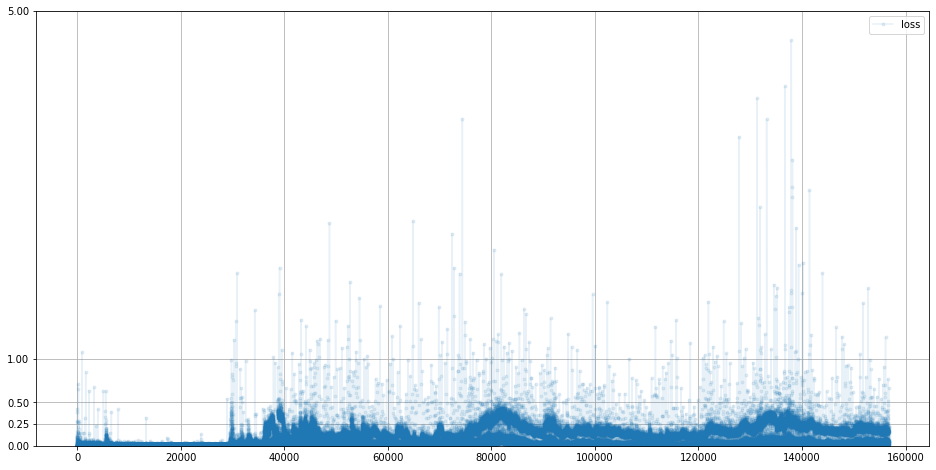

In [27]:
D.plot_progress()

In [28]:
i = 0
for smiles,label in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.unsqueeze(1).repeat(1, smiles.shape[1], 1)
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 4):
        break
    pass

for i in range(4):
    fake_input = []
    fake_label = []
    for finput, label in generate_random_seed(batch_size):
        fake_input.append(finput)
        fake_label.append(label)
    
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    
    #fake_input = fake_input.reshape(1, fake_input.shape[0], fake_input.shape[1])
    fake_label = torch.FloatTensor(fake_label).to(device)
    #print('2.before change label.shape', fake_input.shape, 'fake_label', fake_label.shape)
    fake_label = fake_label.unsqueeze(1).repeat(1, fake_input.shape[1], 1)
    #print('fake_input.shape', fake_input.shape, 'fake_label.shape', fake_label.shape)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    D.forward(fake_input, fake_label)
    pass


tensor([[[0.7381],
         [0.5856],
         [1.2295],
         [0.2854],
         [0.5607],
         [0.5560],
         [0.6502],
         [1.0521],
         [0.5683],
         [0.6974],
         [0.8121],
         [0.6231],
         [0.9959],
         [0.5540],
         [0.7885],
         [0.9097],
         [0.8614],
         [0.2091],
         [0.7848],
         [1.0985],
         [0.9163],
         [1.0863],
         [0.5902],
         [0.9706],
         [0.8149],
         [0.9179],
         [0.6517],
         [0.9844],
         [0.9035],
         [1.3146],
         [0.2576],
         [0.8211],
         [0.7034],
         [0.5467],
         [1.0588],
         [1.0620],
         [0.9156],
         [2.0972],
         [0.7850],
         [0.3807],
         [0.6638],
         [0.6025],
         [0.6177],
         [0.4744],
         [0.6777],
         [0.4050],
         [0.5474],
         [0.9141],
         [0.9363],
         [0.5940],
         [1.0389],
         [0.7315],
         [0.

In [29]:
G.get_smiles(-12.2323)

C1CC[NH2+]CC2=C(CC1)C=NN2


In [34]:
G.get_smiles(0.93)

S=C1NCCCCCN1


In [37]:
G.get_smiles(64.32)

S1N=CC2=C1N=NC=C2


In [39]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN12G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN12D' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(D, open(D_filename, 'wb'))


#G_model = pickle.load(open(G_filename, 'rb'))

save model to file: pre_train_model/GAN12G202104120651.sav
save model to file: pre_train_model/GAN12G202104120651.sav
